# **Jose Ángel Pertuz Montes**
# **Miguel Ángel Banda Del Valle**

In [84]:
%matplotlib inline

import io
import sys
import os
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from nltk import TweetTokenizer
from sklearn import datasets, linear_model
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LogisticRegression

# Import dataset

In [85]:
raw = pd.read_csv('../input/twitter/TASS2018.csv', sep=';')
raw

,tweetid,user,content,date,lang,polarity
0,770976639173951488,noseashetero,@noseashetero 1000/10 de verdad a ti que voy a...,31/08/2016 13:28,es,P
1,771092421866389508,Templelx,@piscolabisaereo @HistoriaNG @SPosteguillo las...,31/08/2016 21:08,es,P
2,771092111429083136,esskuu94,"Al final han sido 3h Bueno, mañana tengo fies...",31/08/2016 21:07,es,P
3,771092070572449796,__ariadna9,@Jorge_Ruiz14 yo no tengo tiempo para esas cos...,31/08/2016 21:07,es,N
4,771094192508600320,_cristtina15_,@_MissChaotic_ ves ese brillo? es un coso que ...,31/08/2016 21:15,es,N
...,...,...,...,...,...,...
501,757593585634213888,RubenRuCh,@Davorias Pero es que está muy rica,25/07/2016 15:09,es,P
502,757585725764362240,rayjaken,@narvalillo Eso es antiguo ya,25/07/2016 14:38,es,N
503,757097408304148480,Fuhyo__,Mi TL esta vacía a estas horas,24/07/2016 6:17,es,N
504,757971881077182464,xLytherinDovah,"Ya tengo uno, pero ese es más cheto @aweamasome.",26/07/2016 16:12,es,NEU


# Dataset description

In [86]:
raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 506 entries, 0 to 505
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   tweetid   506 non-null    int64 
 1   user      506 non-null    object
 2   content   506 non-null    object
 3   date      506 non-null    object
 4   lang      506 non-null    object
 5   polarity  506 non-null    object
dtypes: int64(1), object(5)
memory usage: 23.8+ KB


# Prediction class

In [87]:
tweet_by_polarity = raw.groupby("polarity", as_index=False)['content'].count()
tweet_by_polarity.head(4)

,polarity,content
0,N,219
1,NEU,69
2,NONE,62
3,P,156


# **Gráfica**

/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


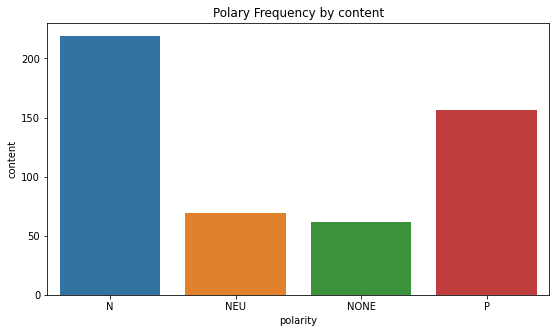

In [88]:
plt.figure(figsize=(9,5))
sns.barplot(tweet_by_polarity['polarity'].values, tweet_by_polarity['content'].values, alpha=1)
plt.title('Polary Frequency by content')
plt.ylabel('content', fontsize=10)
plt.xlabel('polarity', fontsize=10)
plt.show()

In [89]:
def features_lexical(text):
    text_tokenizer = TweetTokenizer()
    tokens_text = text_tokenizer.tokenize(text)
    return tokens_text

# Features
- Número de caracteres por tuit
- Promedio ponderado de caracteres por tuit  (#cartares/240)
- Número menciones 
- Número emojis
- Número de palabras
- Número de caracteres especiales

In [90]:
twchar=[] #Chars per tuit
twprom=[] #Weighted average number of characters
twword=[] #Words per tuit
twats=[] #Mentions per tuit
twemoji=[] # #Emojis
twesp=[] #Especial chars
for row in raw['content']: #Identificar las respectivas características por comentario
    twchar.append(len(row))
    twprom.append(len(row)/240)
    twats.append(row.count("@")) #Tener que existe la posibilidad de que exista un "@" sin que se mencione a una persona
    a=re.findall(r'[^\w\s\@/|°!"#$%&)(=?¿¡¨*}{<>",.:+-^\']',row)
    twemoji.append(np.size(a))
    twword.append(len(features_lexical(row)))
    b=re.findall(r'[^\w\s\@]',row)
    twesp.append(np.size(b)-np.size(a))

# **Adding new features to Dataframe**

In [91]:
raw['N° chars']=twchar
raw['# char/240']=twprom
raw['# words']=twword
raw['# mentions']=twats
raw['# emojis']=twemoji
raw['# esp char']=twesp
raw

,tweetid,user,content,date,lang,polarity,N° chars,# char/240,# words,# mentions,# emojis,# esp char
0,770976639173951488,noseashetero,@noseashetero 1000/10 de verdad a ti que voy a...,31/08/2016 13:28,es,P,96,0.400000,20,1,1,1
1,771092421866389508,Templelx,@piscolabisaereo @HistoriaNG @SPosteguillo las...,31/08/2016 21:08,es,P,95,0.395833,14,3,0,1
2,771092111429083136,esskuu94,"Al final han sido 3h Bueno, mañana tengo fies...",31/08/2016 21:07,es,P,71,0.295833,16,0,0,3
3,771092070572449796,__ariadna9,@Jorge_Ruiz14 yo no tengo tiempo para esas cos...,31/08/2016 21:07,es,N,61,0.254167,10,1,0,0
4,771094192508600320,_cristtina15_,@_MissChaotic_ ves ese brillo? es un coso que ...,31/08/2016 21:15,es,N,69,0.287500,15,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...
501,757593585634213888,RubenRuCh,@Davorias Pero es que está muy rica,25/07/2016 15:09,es,P,36,0.150000,7,1,0,0
502,757585725764362240,rayjaken,@narvalillo Eso es antiguo ya,25/07/2016 14:38,es,N,30,0.125000,5,1,0,0
503,757097408304148480,Fuhyo__,Mi TL esta vacía a estas horas,24/07/2016 6:17,es,N,31,0.129167,7,0,0,0
504,757971881077182464,xLytherinDovah,"Ya tengo uno, pero ese es más cheto @aweamasome.",26/07/2016 16:12,es,NEU,49,0.204167,11,1,0,2


# **Giving values to data, Polarity**

In [92]:
polarity_norm=[]
for row in raw['polarity']:
    if row == 'NONE':
        polarity_norm.append(0)
    if row == 'NEU':
        polarity_norm.append(2)
    if row == 'N':
        polarity_norm.append(1)
    if row == 'P':
        polarity_norm.append(3)

# Define data (train/test) & train the model

# For #Chars

In [93]:
# Split the data into training/testing sets
y_train = twchar[:-101] #No considering the latter 101 values
y_test = twchar[-101:] #Considering the latter 101 values 

# Split the targets into training/testing sets
X_train = polarity_norm[:-101]
X_test = polarity_norm[-101:]

X_train=np.reshape(X_train,(405,1))
X_test=np.reshape(X_test,(101,1))

# Create linear regression object

regr = linear_model.LinearRegression()

# Train the model using the training sets
regr.fit(X_train,y_train)

LinearRegression()

In [94]:
# Make predictions using the testing set
y_pred = regr.predict(X_test)

In [95]:
# The coefficients
print('Coefficients: \n', regr.coef_)
# The mean squared error
print('Mean squared error: %.2f'
      % mean_squared_error(y_test, y_pred))
# The coefficient of determination: 1 is perfect prediction
print('Coefficient of determination: %.2f'
      % r2_score(y_test, y_pred))

Coefficients: 
 [0.9847649]
Mean squared error: 2655.76
Coefficient of determination: -0.33


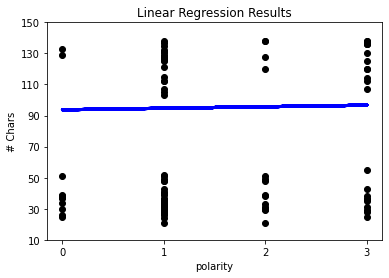

In [96]:
# Plot outputs
plt.scatter(X_test, y_test,  color='black')
plt.plot(X_test, y_pred, color='blue', linewidth=3)
plt.xticks(range(0,4,1))
plt.yticks((range(10,160,20)))
plt.title('Linear Regression Results')
plt.ylabel('# Chars', fontsize=10)
plt.xlabel('polarity', fontsize=10)
plt.show()

# For #Words

In [97]:
# Split the data into training/testing sets
y_train = twword[:-101] #No considering the latter 101 values
y_test = twword[-101:] #Considering the latter 101 values 

# Split the targets into training/testing sets
X_train = polarity_norm[:-101]
X_test = polarity_norm[-101:]

X_train=np.reshape(X_train,(405,1))
X_test=np.reshape(X_test,(101,1))

# Create linear regression object

regr = linear_model.LinearRegression()

# Train the model using the training sets
regr.fit(X_train,y_train)

LinearRegression()

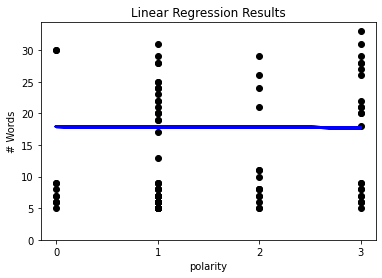

In [98]:
# Make predictions using the testing set
y_pred = regr.predict(X_test)

# Plot outputs
plt.scatter(X_test, y_test,  color='black')
plt.plot(X_test, y_pred, color='blue', linewidth=3)
plt.xticks(range(0,4,1))
plt.yticks((range(0,35,5)))
plt.title('Linear Regression Results')
plt.ylabel('# Words', fontsize=10)
plt.xlabel('polarity', fontsize=10)
plt.show()

In [99]:
polarity_norm=[]
for row in raw['polarity']:
    if row == 'NONE':
        polarity_norm.append(0)
    if row == 'NEU':
        polarity_norm.append(0)
    if row == 'N':
        polarity_norm.append(0)
    if row == 'P':
        polarity_norm.append(1)

# **Logistic regression for #Word**

In [100]:
# Split the data into training/testing sets
X_train = twword[:-101] #No considering the latter 101 values
X_test = twword[-101:] #Considering the latter 101 values 

# Split the targets into training/testing sets
y_train = polarity_norm[:-101]
y_test = polarity_norm[-101:]

X_train=np.reshape(X_train,(405,1))
X_test=np.reshape(X_test,(101,1))

# Create logistic regression 
log_reg = LogisticRegression()
log_reg.fit(X_train, y_train)

LogisticRegression()

In [101]:
y_prob = log_reg.predict_proba(X_test)

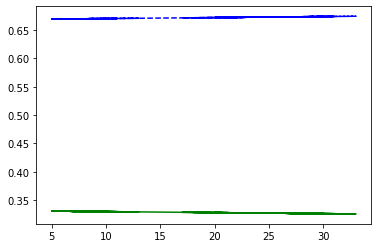

In [102]:
plt.plot(X_test, y_prob[:, 1], "g-", label="Polarity P")
plt.plot(X_test, y_prob[:, 0], "b--", label="Not Polarity P")

In [103]:
polarity_norm=[]
for row in raw['polarity']:
    if row == 'NONE':
        polarity_norm.append(0)
    if row == 'NEU':
        polarity_norm.append(1)
    if row == 'N':
        polarity_norm.append(0)
    if row == 'P':
        polarity_norm.append(0)

In [104]:
# Split the data into training/testing sets
X_train = twemoji[:-101] #No considering the latter 101 values
X_test = twemoji[-101:] #Considering the latter 101 values 

# Split the targets into training/testing sets
y_train = polarity_norm[:-101]
y_test = polarity_norm[-101:]

X_train=np.reshape(X_train,(405,1))
X_test=np.reshape(X_test,(101,1))

# Create logistic regression 
log_reg = LogisticRegression()
log_reg.fit(X_train, y_train)

LogisticRegression()

In [105]:
y_prob = log_reg.predict_proba(X_test)

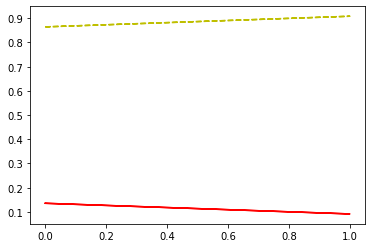

In [106]:
plt.plot(X_test, y_prob[:, 1], "r-", label="Polarity Neutral")
plt.plot(X_test, y_prob[:, 0], "y--", label="Not Polarity Neutral")

In [107]:
polarity_norm=[]
for row in raw['polarity']:
    if row == 'NONE':
        polarity_norm.append(0)
    if row == 'NEU':
        polarity_norm.append(2)
    if row == 'N':
        polarity_norm.append(1)
    if row == 'P':
        polarity_norm.append(3)
np.shape(polarity_norm)

(506,)

In [108]:
# Split the data into training/testing sets
X1 = twchar[:-101] #No considering the latter 101 values
X1_test = twchar[-101:] #Considering the latter 101 values
X2 = twword[:-101] #No considering the latter 101 values
X2_test = twword[-101:] #Considering the latter 101 values 

# Split the targets into training/testing sets
y_train = np.array(polarity_norm[:-101])
y_test = np.array(polarity_norm[-101:])

Xtrain=[X1,X2]
X_train=np.transpose(Xtrain)

Xtest=[X1_test,X2_test]
X_test=np.transpose(Xtest)

# **Softmax regression**

In [109]:
softmax_reg= LogisticRegression(multi_class="multinomial",solver="newton-cg", C=10)
softmax_reg.fit(X_train,y_train)

LogisticRegression(C=10, multi_class='multinomial', solver='newton-cg')

In [110]:
result=(softmax_reg.predict_proba(X_test))
y_predict=[]
b=[]
for i in result:
    a = max(i)
    for j in range(4):
        if i[j]==a:
            b=j
    y_predict.append(b)

# Probabilidad de clases

In [111]:
result

array([[0.12028208, 0.41107033, 0.1145478 , 0.35409979],
       [0.1629059 , 0.27111232, 0.15304426, 0.41293752],
       [0.16143173, 0.27098159, 0.14683698, 0.4207497 ],
       [0.13035662, 0.36986092, 0.11904826, 0.38073419],
       [0.15760524, 0.27837685, 0.13959432, 0.4244236 ],
       [0.14918538, 0.31467348, 0.14231573, 0.39382541],
       [0.09000485, 0.52875306, 0.087711  , 0.29353109],
       [0.14355845, 0.32683609, 0.13159253, 0.39801294],
       [0.09220139, 0.51921992, 0.08933907, 0.29923962],
       [0.14066376, 0.33976132, 0.13216847, 0.38740645],
       [0.09952841, 0.48542731, 0.09301208, 0.3220322 ],
       [0.07253836, 0.6029457 , 0.07164667, 0.25286927],
       [0.08288627, 0.56222006, 0.08374953, 0.27114413],
       [0.09952841, 0.48542731, 0.09301208, 0.3220322 ],
       [0.15062984, 0.30205975, 0.1357253 , 0.41158512],
       [0.11771527, 0.43034561, 0.12096352, 0.3309756 ],
       [0.16374021, 0.26347117, 0.14808725, 0.42470137],
       [0.15422447, 0.3065047 ,

# **Prediction**

In [112]:
y_predict

[1,
 3,
 3,
 3,
 3,
 3,
 1,
 3,
 1,
 3,
 1,
 1,
 1,
 1,
 3,
 1,
 3,
 3,
 1,
 1,
 3,
 1,
 3,
 1,
 3,
 1,
 1,
 3,
 3,
 1,
 3,
 1,
 1,
 1,
 1,
 1,
 3,
 3,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1]

In [113]:
mse=(np.square(y_test - y_predict)).mean()
mse

1.3267326732673268